This notebook contains the scripts to:
fitting nodes to various curves on all 268 nodes

Goal: Find the function that can best characterize a node timecourse. Measure fit using Rsq and AIC

Fits performed using lmfit

In [1]:
# RUN THIS CELL
# import packages, check folders
#%reset
from pathlib import Path
import os
import numpy as np
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
import pickle

%matplotlib inline

working_dir = '/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code'
#working_dir = os.getcwd()
print('current directory:\n',working_dir)
path = Path(working_dir)
parent_folder = path.parent
#print('parent folder:', parent_folder)
data_file_loc = os.path.join(parent_folder,'data') # to store data we extract later in this notebook

current directory:
 /Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/code


In [2]:
vidnames = ["COAXING-B", "BILLIARD-A", "DRIFTING-A", "Fishing", 
            "Random mechanical", "Scaring", "SEDUCING-B", "STAR-A", 
            "SURPRISING-B", "TENNIS-A"]

In [3]:
# load each movie
movie_ind = 4
fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
print(fileName)
movieTC = np.load(fileName) # nsubs * nnodes * ntimepts

/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data/timecourse-movie4.npy


In [4]:
movieTC.shape #subs, nodes, timepts

(1049, 268, 43)

In [5]:
data_file_loc

'/Users/f0053cz/Dropbox (Dartmouth College)/postdoc_Dartmouth/HCP/fMRIScipts/data'

### Load timecourse data for a movie

In [4]:
# RUN THIS CELL
def get_training_instances_matrix(movie_ind):
    fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
    #print('opening file ',fileName)
    movieTC = np.load(fileName) # nsubs * nnodes * ntimepts
    movieTC = movieTC[:,:,:28]
    X = np.mean(movieTC, axis = 0) #nodes, timepts
    return X,movieTC

(268, 28)

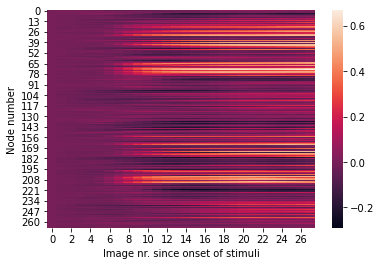

In [5]:
movie_ind = 4
X,movieTC = get_training_instances_matrix(movie_ind)
sns.heatmap(X)
plt.xlabel('Image nr. since onset of stimuli')
plt.ylabel('Node number')
X.shape

### Curve-fitting of nodes using lmfit

In this section, I explore which curves can best explain the temporal changes of nodes - especially those that show sigmoid shapes, such as cluster 1 in the 3- and 4-cluster conditions show in the figures above. Since cluster 0 in both cases also show a linear trend (special case of sigmoid), I try to fit both clusters with the same function. First I explore two functions' parameters below:
1. sigmoid: y = a / (1. + np.exp(-c * (x - d))) + b
2. logistic_regression: y= A*(1 - (1/ (1+np.exp((x-c)/s)) ))

I also use the lmfit package to fit the curves since it is robust and offers options to initialise, set bounds etc.

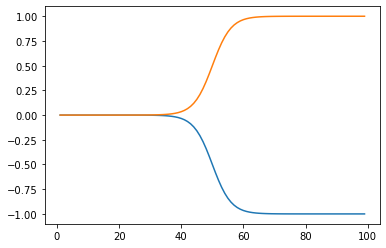

In [376]:
# logistic curve properties
# can explore the effect of A,c,s here

def logistic_function(x, A, c, s):
    return A*(1 - (1/ (1+np.exp((x-c)/s)) ))


x= np.arange(1,100)
A= -1#amplitude
c=x[int(len(x)/2)]#centre
s=3#standard dev
plt.plot(x,logistic_function(x, A, c, s))
A = 1
plt.plot(x,logistic_function(x, A, c, s))

In [109]:
# RUN THIS CELL
from lmfit.models import StepModel, LinearModel, SineModel
from lmfit import Model

In [84]:
def fit_goodness_test(y,result):
    # function returns R-squared value  (defined as 1 - ratio  of residual to 
    # total variance's sums of squares) 
    # for a given timecourse "y" and fit result "result"
    
    yfit = result.best_fit
    res = y-yfit
    ss_res = np.sum((res - np.mean(res))** 2)# or ss_res = res.var()
    ss_tot = np.sum((y   - np.mean(y))  ** 2)# or ss_tot = y.var()
    
    r2 = 1 - (ss_res / ss_tot)
    #print('r2: ', r2)
    
    return r2

### below are functions for each math. function's fit to a given timecourse

In [612]:
def logfit(y,r2_thr,plot_fig=0):
    # computes the best fit using a logistic function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    model = Model(logistic_function)#,nan_policy = 'omit') # set model here
    model.set_param_hint('A', min=-10, max = 10) # set a parameter's range here
    model.set_param_hint('c', min=2, max = 25)
    model.set_param_hint('s', min=.1, max = 500)
    
    params = model.make_params(c=np.argmax(np.diff(y)), 
                                   A = max(y)-min(y), s = 1)  # set initial parameter value here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # A,c,s for logisticfn
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    
    if plot_fig:
        result.plot()
        plt.suptitle('Logistic,Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    if r2 > r2_thr:
        for pind,pname in enumerate(param_keys):
            params_best[pind] = result.best_values[pname] 
    else:
        params_best[:] = np.nan
        
    return params_best,param_keys,r2,result.aic

#### Next three cells are a slight detour exploring the above function and lmfit results using simulated data

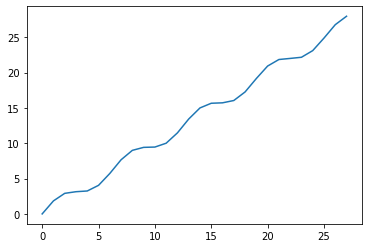

In [395]:
x = np.arange(28)
y = np.sin(x) + x
plt.plot(x,y)

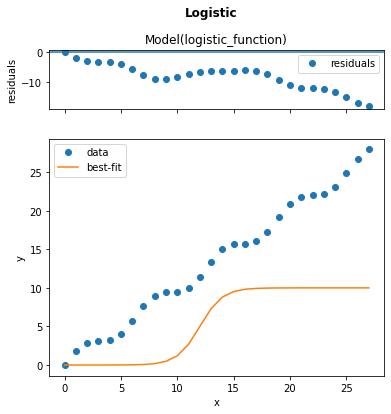

In [396]:
params_best,param_keys,r2,result = logfit(y,r2_thr,1)

In [397]:
result

In [401]:
result.best_values

{'A': 10.0, 'c': 12.0, 's': 0.9999999999999961}

In [399]:
print(result.fit_report())

[[Model]]
    Model(logistic_function)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 12
    # data points      = 28
    # variables        = 3
    chi-square         = 2328.11744
    reduced chi-square = 93.1246975
    Akaike info crit   = 129.777101
    Bayesian info crit = 133.773714
[[Variables]]
    A:  10.0000000 +/- 1.1296e-08 (0.00%) (init = 10)
    c:  12.0000000 +/- 2.50860890 (20.91%) (init = 12)
    s:  1.00000000 +/- 2.21123260 (221.12%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(A, s) = -0.338
    C(A, c) = -0.335
    C(c, s) =  0.113


In [656]:
def linfit(y,r2_thr,plot_fig):
    # computes the best fit using a linear function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    model = LinearModel()  # set model here
    model.set_param_hint('intercept', min=-5, max = 5) # set a parameter's range here
    
    params = model.make_params(intercept=y[0],slope = 1) # set initial parameter values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,c,s for logisticfn
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    
    if plot_fig:
        result.plot()
        plt.suptitle('Linear, Rsq=' + str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    if r2 > r2_thr:
        for pind,pname in enumerate(param_keys):
            params_best[pind] = result.best_values[pname] 
    else:
        params_best[:] = np.nan
    return params_best, param_keys, r2, result.aic

In [613]:
def loglinfit(y,r2_thr, plot_fig):
    # computes the best fit using a logistic + linear function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    # used this function for later yes/no curve fits that's why this function is written in a little more detail
    form = 'logistic'
    model = StepModel(form=form) + LinearModel() # set model here
    model.set_param_hint('intercept', min=-5, max = 5) # set a parameter's range here
    model.set_param_hint('amplitude', min=-10, max = 10)
    model.set_param_hint('center', min=2, max = 28)
    model.set_param_hint('sigma', min=.1, max = 500)
    
    params = model.make_params(intercept=y[0], amplitude=1,
                               center=np.argmax(np.diff(y)),
                                   sigma = 1 ) # set initial values here
    nparams = 5
    params_best = np.empty((5,))
    try:
        result = model.fit(y, params, x=np.arange(0,28))
        param_keys = list(result.best_values.keys()) # E.g. A,c,s for logisticfn
        param_keys.remove('form')
        
        r2 = fit_goodness_test(y, result)

        if plot_fig:
            result.plot()
            plt.suptitle('Linear+Log, Rsq=' + str(np.round(r2,2)),fontweight = 'bold')
            print(result.fit_report())
            print("Rsq: ",r2)
        #print(result.best_values)
        if r2 > r2_thr:
            for pind,pname in enumerate(param_keys):
                params_best[pind] = result.best_values[pname]
        else:
            params_best[:] = np.nan
    except:
        params_best[:] = np.nan
        param_keys = np.nan
        r2 = np.nan
        
        
    return params_best,param_keys, r2,result.aic

In [614]:
def sinefit(y,r2_thr,plot_fig):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    model = SineModel() # set function here
    model.set_param_hint('amplitude', max = 6) # set param range here
    model.set_param_hint('frequency', max = 5)
    
    params = model.make_params(amplitude = 1, frequency = 1,
                               shift = 0 ) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Sinusoidal, Rsq='+str(np.round(r2,2)),fontweight = 'bold')
    #print(result.best_values)
    if r2 > r2_thr:
        for pind,pname in enumerate(param_keys):
            params_best[pind] = result.best_values[pname]
    else:
        params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic

In [615]:
def linsinefit(y,r2_thr,plot_fig):
    # computes the best fit using a sinusoidal function for a timecourse y
    # Returns best fit parameters that are above the rsquared threshold r2_thr,
    # keys (i.e., param names), rsq and aic.
    #plot_fig =0 (don't plot) or 1 (plot)
    
    
    model = SineModel() + LinearModel() # set model here
    model.set_param_hint('amplitude', max = 6) # set parameter ranges here
    model.set_param_hint('frequency', max = 5)
    model.set_param_hint('intercept', min=-5, max = 5)
    
    params = model.make_params(amplitude = 1, frequency = 1,
                               shift = 0, intercept=y[0],slope = 1 ) # set initial param values here
    
    result = model.fit(y, params, x=np.arange(0,28))
    param_keys = list(result.best_values.keys()) # E.g. A,freq,ph
    params_best = np.zeros((len(param_keys),))
    r2 = fit_goodness_test(y, result)
    if plot_fig:
        result.plot()
        plt.suptitle('Linear+Sinusoidal, Rsq='+ str(np.round(r2,2)),fontweight = 'bold')    
    #print(result.best_values)
    if r2 > r2_thr:
        for pind,pname in enumerate(param_keys):
            params_best[pind] = result.best_values[pname]
    else:
        params_best[:] = np.nan
        
    return params_best,param_keys, r2, result.aic

In [616]:
def function_fits(movie_ind,r2_thr, responses, node_plot, movie_plot):
    # function to test various curves' fits. returns fit-goodness metrics (rsq and aic) of all curves
    # input params: movie_ind (0-9 based on index in vidnames variable), r2_thr: rsq threshold,
    # responses: a subject*movies matrix of responses (1=yes,0=no,9=unsure, -1=no response)
    # node_plot: node nr to be plotted (1-268), 0 for not plotting
    # movie_plot: movie_ind to be plotted, -1 for not plotting
    
    #print('Movie: ', vidnames[movie_ind],'.')
    
    X,movieTC = get_training_instances_matrix(movie_ind)
    
    # get yes/no/unsure indices
    resp_any = (responses[:,movie_ind] == 0)| (responses[:,movie_ind] == 1) | \
                (responses[:,movie_ind] == 9)

    # mean timecourses across yes/no responders for a certain movie (defined in the previous node)
    meanTimecourse_anyresp = np.mean(movieTC[resp_any,:,:],axis = 0) # nodes, timepts
    
    nfunctions = 5
    r2_all    = np.empty((268,nfunctions)) # nodes, fn 0,1,2,3
    r2_all[:] = np.nan
    
    aic_all    = np.empty((268,nfunctions)) # nodes, fn 0,1,2,3
    aic_all[:] = np.nan
    
    params_array_allfns = []
        
    for fn in range(nfunctions):# find best-fitting function
        for node in range(268):
            yanyresp = meanTimecourse_anyresp[node,:]
            if (node == node_plot-1) and (movie_ind == movie_plot):
                plot_fig = 1
            else:
                plot_fig = 0
            if fn == 0:
                params_best,param_keys,r2,aic = logfit(yanyresp,r2_thr,plot_fig)
            elif fn == 1:
                params_best,param_keys,r2,aic = linfit(yanyresp,r2_thr,plot_fig)
            elif fn == 2:
                params_best,param_keys,r2,aic = loglinfit(yanyresp,r2_thr,plot_fig)
            elif fn == 3:
                params_best,param_keys,r2,aic = sinefit(yanyresp,r2_thr,plot_fig)
            elif fn == 4:
                params_best,param_keys,r2,aic = linsinefit(yanyresp,r2_thr,plot_fig)
                

            if node ==0:
                params_array    = np.empty((268,len(param_keys))) # nodes, params, yes/no/unsure/all
                params_array[:] = np.nan
            params_array[node,:] = params_best
            r2_all[node,fn] = r2
            aic_all[node,fn] = aic
        params_array_allfns.append(params_array)
            
            
    return params_array_allfns,r2_all, aic_all

In [617]:
# RUN THIS CELL
#load behavioral responses, a subject*movies matrix of responses (1=yes,0=no,9=unsure, -1=no response)
responses = np.load(os.path.join(data_file_loc,'responses_slopereg.npy'))
responses.shape

(1049, 10)

Elapsed time: 0.00017690658569335938 ,  0 .  COAXING-B
[[Model]]
    (Model(step, form='logistic') + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 116
    # data points      = 28
    # variables        = 5
    chi-square         = 0.01725661
    reduced chi-square = 7.5029e-04
    Akaike info crit   = -196.969402
    Bayesian info crit = -190.308380
[[Variables]]
    amplitude: -0.47796569 +/- 2.44404234 (511.34%) (init = 1)
    center:     27.9999996 +/- 26.2087873 (93.60%) (init = 20)
    sigma:      7.43491767 +/- 22.1835601 (298.37%) (init = 1)
    slope:      0.00969134 +/- 0.01694307 (174.83%) (init = 1)
    intercept: -0.02063743 +/- 0.10943594 (530.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)     = -0.997
    C(sigma, intercept)     =  0.993
    C(amplitude, intercept) = -0.985
    C(amplitude, center)    =  0.977
    C(center, sigma)        = -0.964
    C(sigma, slope)         =  0.

,Movie_ind,Nodes,Rsq_Logistic,Rsq_Linear,Rsq_Loglinear,Rsq_Sinusoidal,Rsq_LinSinusoidal,AIC_Logistic,AIC_Linear,AIC_Loglinear,AIC_Sinusoidal,AIC_LinSinusoidal
0,0.0,0.0,0.753224,0.665214,0.985410,0.010569,0.680474,-190.199327,-199.954183,-281.682533,-167.601130,-195.260500
1,0.0,1.0,0.323729,0.175278,0.385245,0.046988,0.245776,-262.317542,-263.751964,-265.978996,-257.196585,-260.253953
2,0.0,2.0,0.492325,0.094676,0.948139,0.000000,0.108539,-226.640086,-212.458822,-286.531311,-168.375903,-206.890903
3,0.0,3.0,0.003153,0.002799,0.616308,0.039968,0.052466,-230.776245,-232.766311,-253.509461,-213.554826,-228.196825
4,0.0,4.0,0.846456,0.452196,0.878967,-0.019930,0.455279,-188.773275,-155.206402,-191.482221,-109.295910,-149.364395


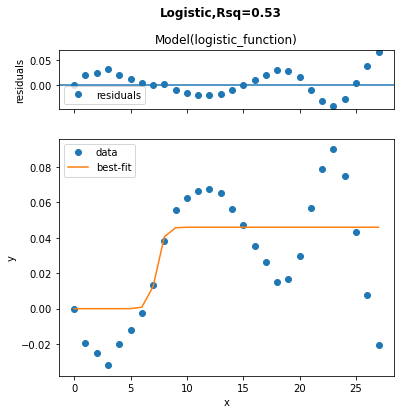

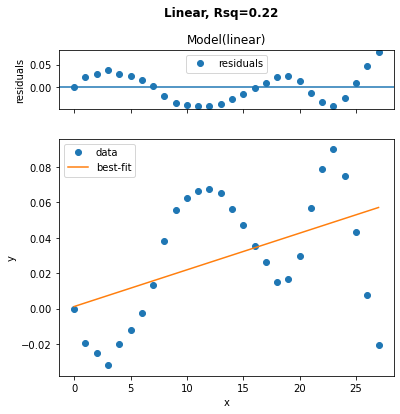

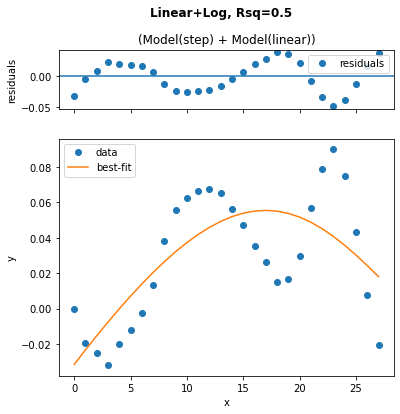

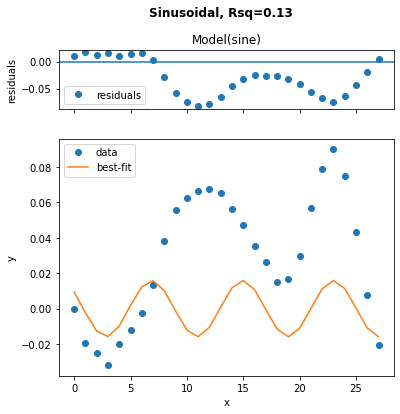

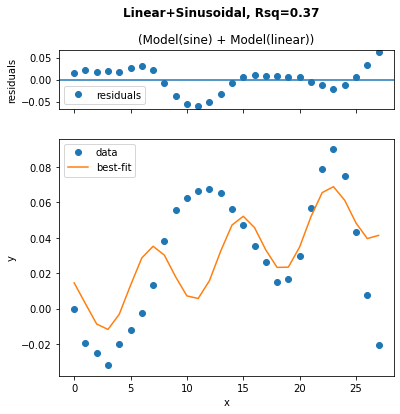

In [618]:
#del df
# getting rsq values for each curve and movie (to be replaced in the future by getting an average timecourse
# across movies and then fitting it)

r2_thr = .6
colnames = ['Movie_ind', 'Nodes', 'Rsq_Logistic', 'Rsq_Linear', 
            'Rsq_Loglinear', 'Rsq_Sinusoidal','Rsq_LinSinusoidal', 'AIC_Logistic', 'AIC_Linear', 
            'AIC_Loglinear', 'AIC_Sinusoidal', 'AIC_LinSinusoidal']
movie_plot = 0 # enter a movie_ind value between 0 an 9
node_plot = 15 # Enter a value between 1 and 268?(incl.). Will subtract by 1 in the functiom
df_modelfits = pd.DataFrame(columns = colnames) 
start = time.time()
for movie_ind in range(10): # list of movies
    print('Elapsed time:',time.time()-start,', ',movie_ind, '. ',vidnames[movie_ind])
    params_array_allfns,r2_all, aic_all = \
        function_fits(movie_ind,r2_thr, responses, node_plot,movie_plot)
    
    movie_ind_col= np.repeat(movie_ind,268, axis=0)
    movie_ind_col = np.reshape(movie_ind_col,(268,1))
    
    nodes_ind = np.arange(0,268)
    nodes_ind = np.reshape(nodes_ind,(268,1))
    
    dat = np.hstack((movie_ind_col, nodes_ind, r2_all, aic_all))
    #print(dat)
    new_row = pd.DataFrame(dat, columns = colnames)
    df_modelfits = pd.concat([df_modelfits, new_row], ignore_index=True)

df_modelfits.head()

In [217]:
avg = df.groupby(["Nodes"]).median()
sem = df.groupby(["Nodes"]).sem()

In [218]:
avg.head()

,Movie_ind,Rsq_Logistic,Rsq_Linear,Rsq_Loglinear,Rsq_Sinusoidal,Rsq_LinSinusoidal,AIC_Logistic,AIC_Linear,AIC_Loglinear,AIC_Sinusoidal,AIC_LinSinusoidal
Nodes,,,,,,,,,,,
0.0,4.5,0.889549,0.719432,0.972138,0.018270,0.732231,-225.243747,-210.739429,-273.703707,-161.432707,-207.015360
1.0,4.5,0.808759,0.779025,0.921863,0.054298,0.796196,-265.266061,-267.003707,-283.324029,-185.223743,-265.461658
2.0,4.5,0.509851,0.107611,0.819520,0.020182,0.138278,-228.809462,-219.448266,-253.392758,-177.003916,-214.811318
3.0,4.5,0.876968,0.830852,0.901168,0.046576,0.848866,-269.272086,-263.762839,-269.478772,-191.369176,-258.227499
4.0,4.5,0.921151,0.588100,0.850030,0.003214,0.593208,-199.476677,-156.261350,-178.634639,-105.530694,-150.811038


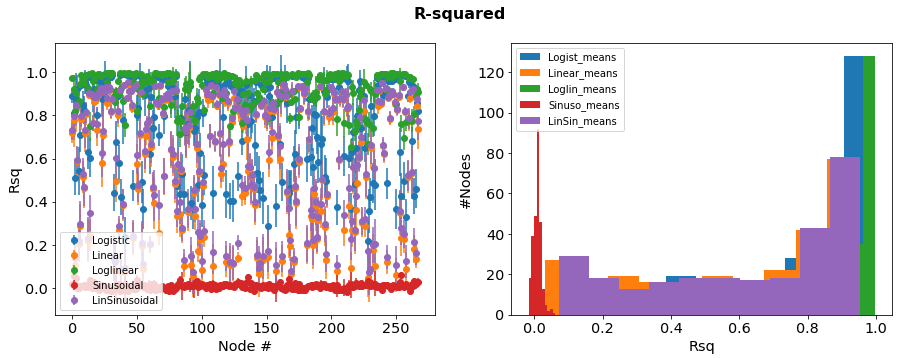

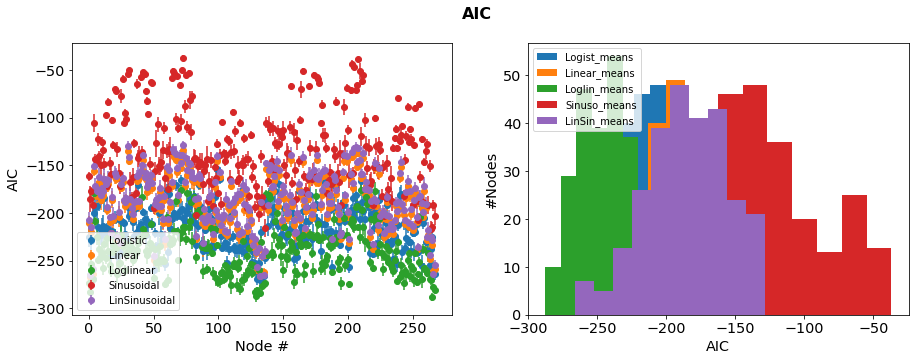

In [219]:
# plotting mean rsq and aic (each averaged across movies and subs) for each fn 

plt.figure(1,figsize = (15,5))
plt.suptitle('R-squared',fontsize = 16, fontweight = 'bold')
cols = ["Rsq_Logistic","Rsq_Linear","Rsq_Loglinear","Rsq_Sinusoidal","Rsq_LinSinusoidal"]
plt.subplot(1,2,1)
for colname in cols:
    plt.errorbar(range(268),avg[colname].values,sem[colname].values,
                 linestyle = "None", marker = 'o',label = colname[4:])
plt.ylabel ("Rsq", fontsize = 'x-large')
plt.xlabel ("Node #", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(avg[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')


plt.figure(2,figsize = (15,5))
plt.suptitle('AIC', fontsize = 16, fontweight = 'bold')
plt.subplot(1,2,1)
cols = ["AIC_Logistic","AIC_Linear","AIC_Loglinear","AIC_Sinusoidal", "AIC_LinSinusoidal"]
for colname in cols:
    plt.errorbar(range(268),avg[colname].values,sem[colname].values,
                 linestyle = "None", marker = 'o',label = colname[4:])
    
plt.ylabel ("AIC", fontsize = 'x-large')
plt.xlabel ("Node #", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(avg[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')

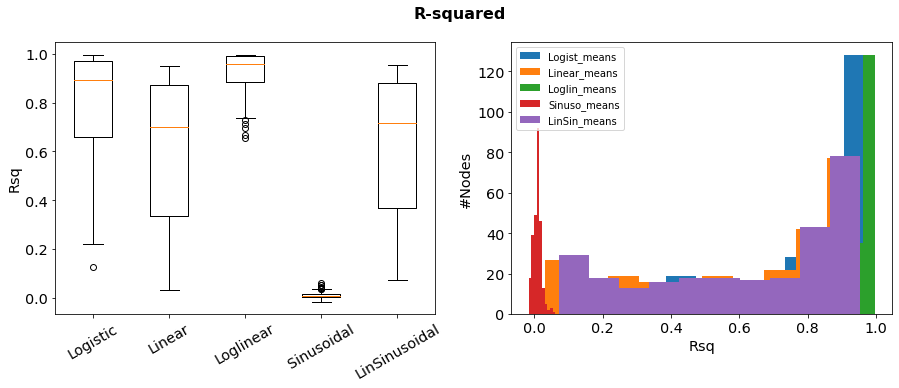

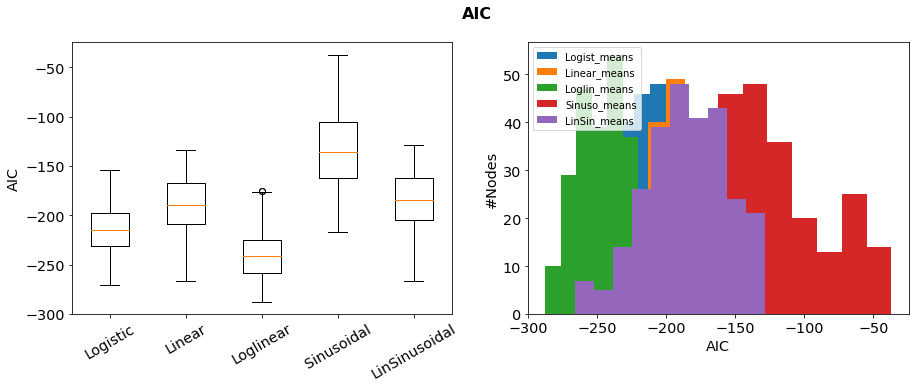

In [338]:
# plotting functionwise fit metrics (rsq and aic)

plt.figure(1,figsize = (15,5))
plt.suptitle('R-squared',fontsize = 16, fontweight = 'bold')
cols = ["Rsq_Logistic","Rsq_Linear","Rsq_Loglinear","Rsq_Sinusoidal","Rsq_LinSinusoidal"]
plt.subplot(1,2,1)
#for n in range(268):
#    plt.errorbar(range(len(cols)),avg[cols].values[n,:],sem[cols].values[n,:],
#                  marker = 'o', linestyle = 'None',color = 'k',alpha = .8)
plt.boxplot(avg[cols].values)
#plt.bar(range(len(cols)),np.nanmean(avg[cols].values,axis=0),
#        color = [.9,.9,.9],)
#plt.errorbar(range(len(cols)),np.nanmean(avg[cols].values,axis=0),
#        stats.sem(avg[cols].values,axis=0, nan_policy='omit'), marker = 'o',
#        color = [0.,0.,0.],linestyle = 'None')

plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
lbls = [i[4:] for i in cols]
plt.xticks(np.arange(1,len(cols)+1),lbls,fontsize='x-large', rotation = 30)
#plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(avg[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')


plt.figure(2,figsize = (15,5))
plt.suptitle('AIC', fontsize = 16, fontweight = 'bold')
plt.subplot(1,2,1)
cols = ["AIC_Logistic","AIC_Linear","AIC_Loglinear","AIC_Sinusoidal", "AIC_LinSinusoidal"]
#for n in range(268):
#    plt.errorbar(range(len(cols)),avg[cols].values[n,:],sem[cols].values[n,:],
#                  marker = 'o', linestyle = 'None')
#plt.bar(range(len(cols)),np.nanmean(avg[cols].values,axis=0),
#        color = [.9,.9,.9],)
#plt.errorbar(range(len(cols)),np.nanmean(avg[cols].values,axis=0),
#        stats.sem(avg[cols].values,axis=0, nan_policy='omit'), marker = 'o',
#        color = [0.,0.,0.],linestyle = 'None')
plt.boxplot(avg[cols].values)
   
plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(np.arange(1,len(cols)+1),lbls,fontsize='x-large', rotation = 30)
#plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(avg[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')

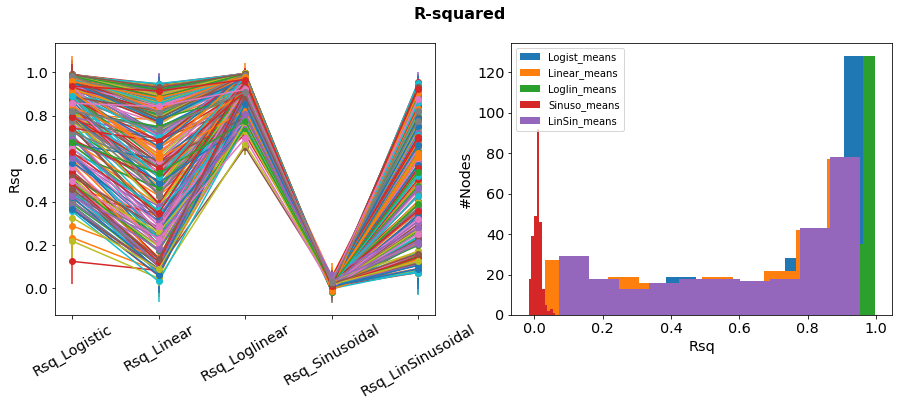

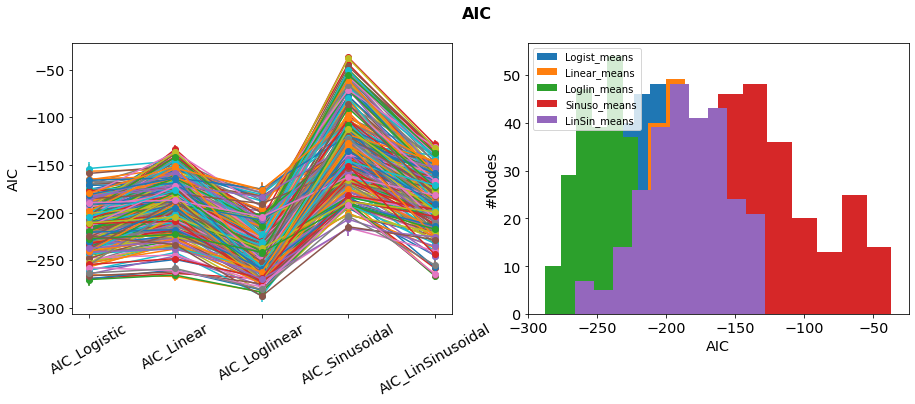

In [227]:
# same as before, but with nodewise info - i.e., each line in the left plots show how well a node fits a function
plt.figure(1,figsize = (15,5))
plt.suptitle('R-squared',fontsize = 16, fontweight = 'bold')
cols = ["Rsq_Logistic","Rsq_Linear","Rsq_Loglinear","Rsq_Sinusoidal","Rsq_LinSinusoidal"]
plt.subplot(1,2,1)
for n in range(268):
    plt.errorbar(range(len(cols)),avg[cols].values[n,:],sem[cols].values[n,:],
                  marker = 'o')
plt.ylabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(range(len(cols)),cols,fontsize='x-large', rotation = 30)
#plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(avg[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("Rsq", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')


plt.figure(2,figsize = (15,5))
plt.suptitle('AIC', fontsize = 16, fontweight = 'bold')
plt.subplot(1,2,1)
cols = ["AIC_Logistic","AIC_Linear","AIC_Loglinear","AIC_Sinusoidal", "AIC_LinSinusoidal"]
for n in range(268):
    plt.errorbar(range(len(cols)),avg[cols].values[n,:],sem[cols].values[n,:],
                  marker = 'o')
    
plt.ylabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(range(len(cols)),cols,fontsize='x-large', rotation = 30)
#plt.legend(loc = 'lower left')

plt.subplot(1,2,2)
for colname in cols:
    plt.hist(avg[colname].values,label = colname[4:10] + '_means')
plt.ylabel ("#Nodes", fontsize = 'x-large')
plt.xlabel ("AIC", fontsize = 'x-large')
plt.yticks(fontsize='x-large')
plt.xticks(fontsize='x-large')
plt.legend(loc = 'upper left')

['Logistic', 'Linear', 'Loglinear', 'Sinusoidal', 'LinSinusoidal']


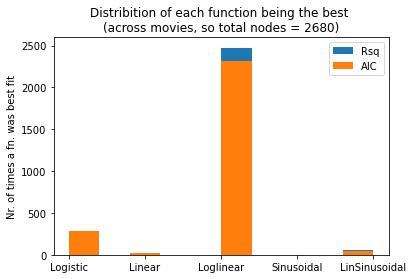

In [641]:
# histogram of the "winning" function as per rsq and aic
cols = ["Rsq_Logistic","Rsq_Linear","Rsq_Loglinear","Rsq_Sinusoidal", "Rsq_LinSinusoidal"]
node_fn_r2based = np.argmax(df_modelfits[cols].values,axis=1)
#plt.plot(node_fn_r2based, color = 'b',linestyle = 'None', marker = 'o')
plt.hist(node_fn_r2based, label = 'Rsq')

cols = ["AIC_Logistic","AIC_Linear","AIC_Loglinear","AIC_Sinusoidal","AIC_LinSinusoidal"]
node_fn_AICbased = np.argmin(df_modelfits[cols].values,axis=1)
#plt.plot(node_fn_AICbased, color = 'r',linestyle = 'None', marker = 'o')

plt.hist(node_fn_AICbased, label ='AIC')
lbls = [i[4:] for i in cols]
print(lbls)
plt.xticks(range(5),lbls)
plt.title('Distribition of each function being the best \n(across movies, so total nodes = 2680)')
plt.ylabel('Nr. of times a fn. was best fit')

plt.legend()
# Highest r2 and Lowest AIC is for the loglin curve o.O

In [642]:
from nltools.data import Brain_Data
from nltools.mask import expand_mask, roi_to_brain

threshold is ignored for simple axial plots


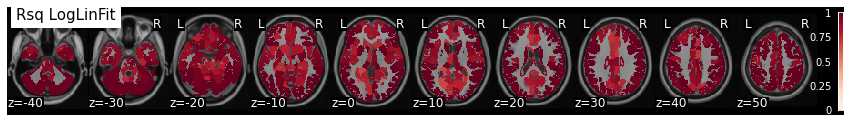

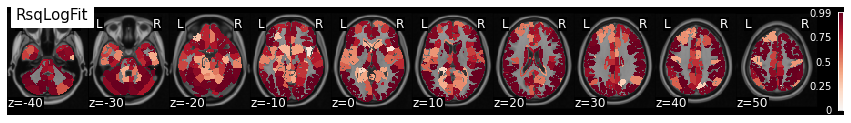

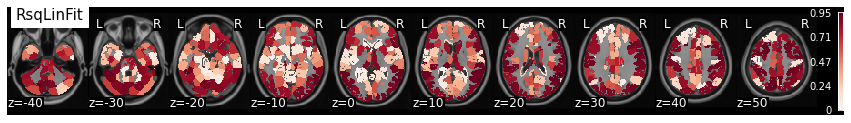

In [643]:
# rsq for different functions across nodes

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

img = roi_to_brain(pd.Series(avg["Rsq_Loglinear"]), mask_x)
img.plot(colorbar=True, title = "Rsq LogLinFit", cmap = 'RdBu_r', threshold_lower = .5)

img = roi_to_brain(pd.Series(avg["Rsq_Logistic"]), mask_x)
img.plot(colorbar=True, title = "RsqLogFit", cmap = 'RdBu_r')

img = roi_to_brain(pd.Series(avg["Rsq_Linear"]), mask_x)
img.plot(colorbar=True, title = "RsqLinFit", cmap = 'RdBu_r')

In [644]:
def response_based_parameters(movie_ind, responses, fn, node_plot,movie_plot):
    # all terms except fn same as the 'function_fits' function
    # fn(0-4) refers to the function number (0: logistic, 1: linear etc.)
    # returns a parameter array with best fitting params for yes and no for all nodes
    
    X,movieTC = get_training_instances_matrix(movie_ind)
    
    # get yes/no indices
    resp_yes = responses[:,movie_ind] == 1
    resp_no = responses[:,movie_ind] == 0
    resp_unsure = responses[:,movie_ind] == 9
    resp_any = (responses[:,movie_ind] == 0)| (responses_slopereg[:,movie_ind] == 1) | (responses_slopereg[:,movie_ind] == 9)

    # mean timecourses across yes/no responders for a certain movie (defined in the previous node)
    meanTimecourse_anyresp = np.mean(movieTC[resp_any,:,:],axis = 0) # nodes, timepts
    meanTimecourse_yes = np.mean(movieTC[resp_yes,:,:],axis = 0) # nodes, timepts
    meanTimecourse_no = np.mean(movieTC[resp_no,:,:],axis = 0) # nodes, timepts
    meanTimecourse_unsure= np.mean(movieTC[resp_unsure,:,:],axis = 0) # nodes, timepts
            
    params_array_allresp = []
    for resp_type in ['Yes','No']:
        for node in range(268):
            if resp_type ==  'Yes':
                y = meanTimecourse_yes[node,:]
            elif resp_type ==  'No':
                y = meanTimecourse_no[node,:]
            if (node == node_plot-1) and (movie_ind == movie_plot):
                plot_fig = 1
                print(str.upper(resp_type))
            else:
                plot_fig = 0    
            if fn == 0:
                params_best,param_keys,_,_ = logfit(y,r2_thr,plot_fig)
            elif fn == 1:
                params_best,param_keys,_,_ = linfit(y,r2_thr,plot_fig)
            elif fn == 2:
                params_best,param_keys,_,_ = loglinfit(y,r2_thr,plot_fig)
            elif fn == 3:
                params_best,param_keys,_,_ = sinefit(y,r2_thr,plot_fig)
            elif fn == 4:
                params_best,param_keys,_,_ = linsinefit(y,r2_thr,plot_fig)

            if node ==0:
                params_array    = np.empty((268,len(param_keys))) # nodes, params, yes/no/unsure/all
                params_array[:] = np.nan
            params_array[node,:] = params_best
        params_array_allresp.append(params_array)

    return params_array_allresp

In [654]:
df_modelfits.loc[(df_modelfits["Rsq_Loglinear"]> .6)&(df_modelfits["Movie_ind"]==0),
                 ["Nodes","Rsq_Loglinear"]]

,Nodes,Rsq_Loglinear
0,0.0,0.985410
2,2.0,0.948139
3,3.0,0.616308
4,4.0,0.878967
5,5.0,0.893562
...,...,...
263,263.0,0.988906
264,264.0,0.939714
265,265.0,0.925803
266,266.0,0.914872


Elapsed time: 0.0001327991485595703 ,  0 .  COAXING-B
YES
[[Model]]
    (Model(step, form='logistic') + Model(linear))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 91
    # data points      = 28
    # variables        = 5
    chi-square         = 7.0179e-04
    reduced chi-square = 3.0512e-05
    Akaike info crit   = -286.634409
    Bayesian info crit = -279.973386
[[Variables]]
    amplitude:  0.11938173 +/- 0.01211569 (10.15%) (init = 1)
    center:     19.5565323 +/- 0.26326135 (1.35%) (init = 22)
    sigma:      1.94298856 +/- 0.29781383 (15.33%) (init = 1)
    slope:     -0.00554092 +/- 4.4119e-04 (7.96%) (init = 1)
    intercept:  0.00361442 +/- 0.00293191 (81.12%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, slope)     = -0.915
    C(amplitude, sigma)     =  0.855
    C(slope, intercept)     = -0.844
    C(sigma, slope)         = -0.695
    C(amplitude, intercept) =  0.663
    C(sigma, intercept)     =  0.426


,Movie_ind,Nodes,slopeYes,interceptYes,AYes,cYes,sYes,slopeNo,interceptNo,ANo,cNo,sNo
0,0.0,0.0,-0.011736,-0.014541,0.445481,17.074008,4.655293,0.001933,0.032673,0.172069,15.43931,1.314751
1,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,2.0,-0.005541,0.003614,0.119382,19.556532,1.942989,NaN,NaN,NaN,NaN,NaN
3,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,4.0,-0.016032,0.055651,0.248153,20.496334,1.348063,NaN,NaN,NaN,NaN,NaN


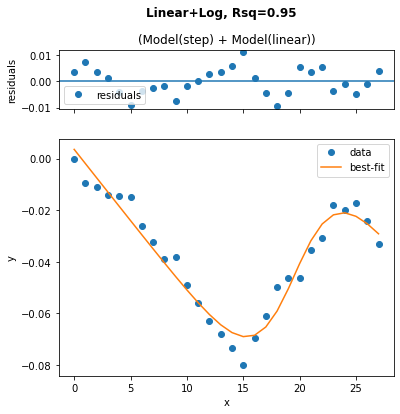

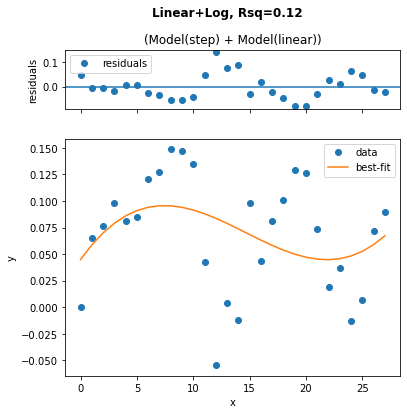

In [655]:
# implementation of the above function for each movie
# info stored as a dataframe
# in later versions, curves will be averaged across movies first

#del df

r2_thr = .6
fn = 2
if fn == 2:
    colnames = ['Movie_ind', 'Nodes','slopeYes','interceptYes', 'AYes','cYes','sYes',
            'slopeNo','interceptNo','ANo','cNo','sNo', ]
node_plot = 3
movie_plot = 0
df_params = pd.DataFrame(columns = colnames) 
start = time.time()
for movie_ind in range(10): # list of movies
    print('Elapsed time:',time.time()-start,', ',movie_ind, '. ',vidnames[movie_ind])
    
    params_array_allresp = response_based_parameters(movie_ind, responses, fn, 
                                                     node_plot, movie_plot)
    params_yes = params_array_allresp[0]
    params_no = params_array_allresp[1]

    movie_ind_col= np.repeat(movie_ind,268, axis=0)
    movie_ind_col = np.reshape(movie_ind_col,(268,1))
    
    nodes_ind = np.arange(0,268)
    nodes_ind = np.reshape(nodes_ind,(268,1))
    
    dat = np.hstack((movie_ind_col, nodes_ind, params_yes, params_no))
    #print(dat)
    new_row = pd.DataFrame(dat, columns = colnames)
    df_params = pd.concat([df_params, new_row], ignore_index=True)

df_params.head()

In [483]:
for pref in ['slope','intercept', 'A','c','s']:
    df_params[pref + 'diff'] = df_params[pref + 'Yes'] - df_params[pref + 'No']

In [486]:
df_params['Rsq_Loglinear'] = df_modelfits["Rsq_Loglinear"]

In [487]:
df_params = df_params.loc[df_params['Rsq_Loglinear']>.6,:]
df_params.head()

,Movie_ind,Nodes,slopeYes,interceptYes,AYes,cYes,sYes,slopeNo,interceptNo,ANo,cNo,sNo,slopediff,interceptdiff,Adiff,cdiff,sdiff,Rsq_Loglinear
0,0.0,0.0,-0.011736,-0.014541,0.445481,17.074008,4.655293,0.001933,0.032673,0.172069,15.439310,1.314751,-0.013669,-0.047213,0.273412,1.634699,3.340542,0.985410
2,0.0,2.0,-0.005541,0.003614,0.119382,19.556532,1.942989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948139
3,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616308
4,0.0,4.0,-0.016032,0.055651,0.248153,20.496334,1.348063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878967
5,0.0,5.0,-0.010370,0.022174,0.333346,20.455682,2.033506,-0.013849,0.004951,0.252896,21.045267,1.957315,0.003479,0.017223,0.080450,-0.589585,0.076191,0.893562


In [488]:
len(df_params)

2593

In [489]:
df_mean = df_params.groupby(["Nodes"]).mean()
if df_mean.index.name == 'Nodes':
    df_mean = df_mean.reset_index()
df_mean.head(20)

,Nodes,Movie_ind,slopeYes,interceptYes,AYes,cYes,sYes,slopeNo,interceptNo,ANo,cNo,sNo,slopediff,interceptdiff,Adiff,cdiff,sdiff,Rsq_Loglinear
0,0.0,4.500000,-0.009983,-0.127330,0.656968,15.093389,3.588497,-0.028451,-0.855247,2.701483,15.647756,8.604390,0.016495,0.697572,-1.918370,-1.226091,-4.671665,0.973001
1,1.0,5.375000,0.000764,-0.079596,0.295279,15.464013,9.149381,0.015857,0.389055,-1.070252,12.456466,13.610356,-0.017212,-0.546255,1.593414,4.219520,-4.967407,0.913804
2,2.0,4.500000,-0.002651,0.019290,0.091313,17.514061,1.929704,-0.003547,0.020200,0.130589,17.763471,2.497515,0.003315,-0.000895,-0.063609,-0.215319,0.400586,0.830457
3,3.0,4.500000,-0.016670,-0.401431,1.291889,14.972654,3.234885,-0.010776,-0.433347,1.176708,10.359921,3.891733,-0.004505,0.085300,-0.022549,4.666445,-1.003689,0.862867
4,4.0,4.888889,-0.017438,0.058636,0.240746,19.184352,1.543055,-0.023044,-0.240005,1.337674,17.912084,4.418206,0.005429,0.299014,-1.097854,1.108270,-2.850778,0.867073
5,5.0,4.500000,-0.010049,0.037471,0.219643,18.760592,1.798530,-0.007404,0.018490,0.151101,20.314412,1.377052,-0.002211,0.015408,0.054976,-2.873146,0.376027,0.829427
6,6.0,4.500000,-0.016692,-0.167036,0.940604,18.022268,3.409844,-0.015388,-0.240559,1.061465,14.422065,5.037490,-0.001304,0.073523,-0.120861,3.600203,-1.627646,0.915988
7,7.0,4.500000,-0.008928,0.010588,0.417475,16.053986,2.406653,-0.010983,0.000371,0.512126,14.752599,2.824692,0.001653,0.011536,-0.068370,1.418288,-0.271940,0.980622
8,8.0,4.500000,-0.009086,0.021938,0.347639,18.644612,2.110181,-0.010552,0.014081,0.392837,18.166823,1.807051,0.001790,0.006537,-0.051866,0.261735,0.196061,0.955052
9,9.0,4.500000,-0.006499,0.005882,0.351045,18.301689,2.680488,-0.016179,-0.341429,1.285974,19.026668,3.515757,0.009681,0.347311,-0.934929,-0.724979,-0.835269,0.929909


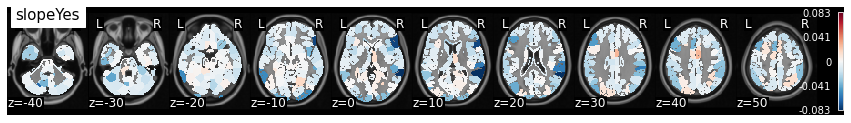

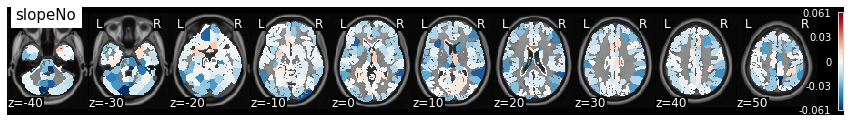

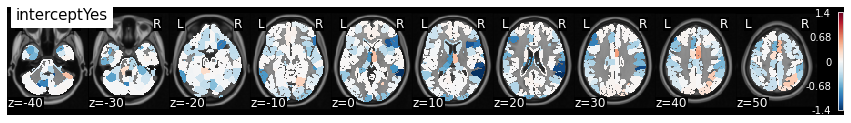

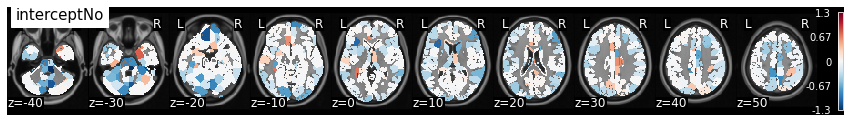

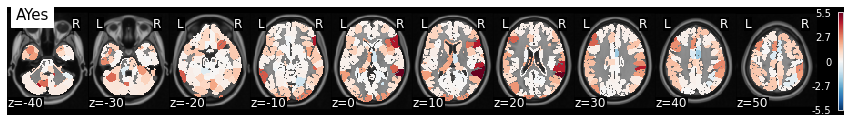

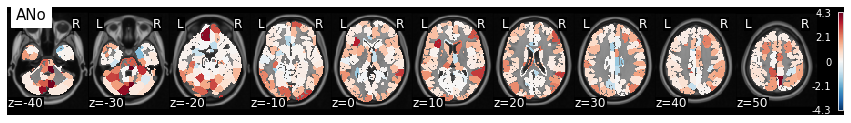

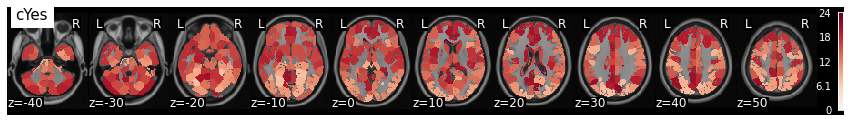

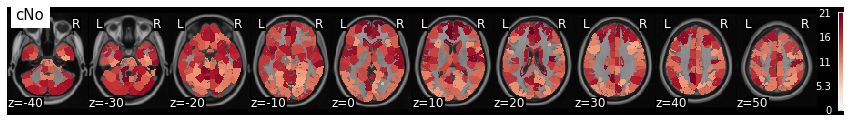

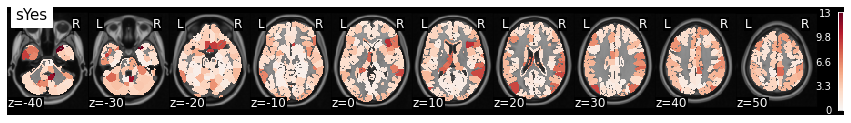

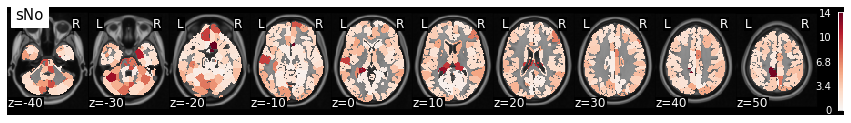

In [490]:
# Plotting various parameters for the best fitting fn (log+linear) for yes and no responders

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

rows = [int(i) for i in df_mean["Nodes"]]
    
for resp in ["slopeYes", "slopeNo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    nodes[rows] = df_mean[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')


for resp in ["interceptYes", "interceptNo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    nodes[rows] = df_mean[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')

for resp in ["AYes", "ANo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    nodes[rows] = df_mean[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')
    
for resp in ["cYes", "cNo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    nodes[rows] = df_mean[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')
    
for resp in ["sYes", "sNo"]:
    nodes = np.empty((268,))
    nodes[:] =np.nan
    rows = [int(i) for i in df1["Nodes"]]
    nodes[rows] = df_mean[resp]
    img = roi_to_brain(pd.Series(nodes), mask_x)
    img.plot(colorbar=True, title = resp, cmap = 'RdBu_r')

In [497]:
shen268[str(227)]

0    {'coords': [-7.461883408071742, -42.134529147982065, 13.399103139013448], 'name': '69.51% Cingulate_Gyrus_posterior_division; 11.21% Left_Lateral_Ventrical; 6.73% Left_Hippocampus; 5.83% no_label'}
Name: 227, dtype: object

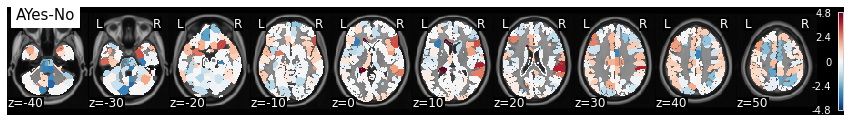

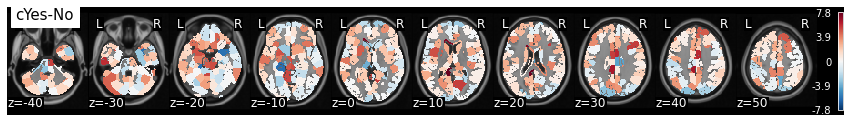

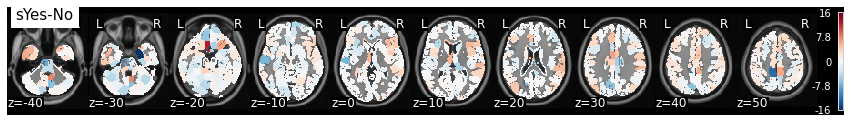

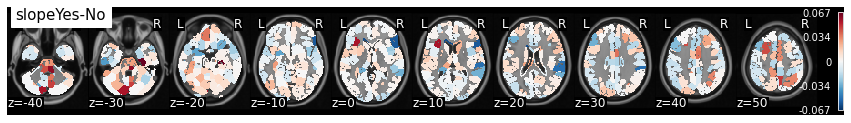

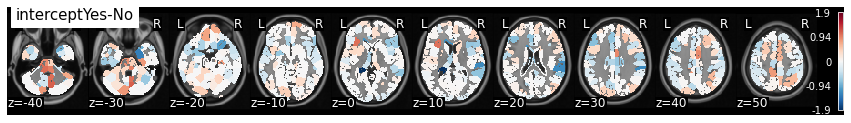

In [504]:
# Plotting differences (yes-no responders) for various parameters of the best fitting fn (log+linear)
# data averaged across movies

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

rows = [int(i) for i in df_mean["Nodes"]]

nodes1 = np.empty((268,))
nodes1[:] =np.nan
nodes1[rows] = df_mean["Adiff"]
img = roi_to_brain(pd.Series(nodes1), mask_x)
img.plot(colorbar=True, title = "AYes-No", cmap = 'RdBu_r')
    
nodes2 = np.empty((268,))
nodes2[:] =np.nan
nodes2[rows] = df_mean["cdiff"]
img = roi_to_brain(pd.Series(nodes2), mask_x)
img.plot(colorbar=True, title =  "cYes-No", cmap = 'RdBu_r')
    
nodes3 = np.empty((268,))
nodes3[:] =np.nan
nodes3[rows] = df_mean["sdiff"]
img = roi_to_brain(pd.Series(nodes3), mask_x)
img.plot(colorbar=True, title = "sYes-No", cmap = 'RdBu_r')

nodes4 = np.empty((268,))
nodes4[:] =np.nan
nodes4[rows] = df_mean["slopediff"]
img = roi_to_brain(pd.Series(nodes4), mask_x)
img.plot(colorbar=True, title = "slopeYes-No", cmap = 'RdBu_r')

nodes5 = np.empty((268,))
nodes5[:] =np.nan
nodes5[rows] = df_mean["interceptdiff"]
img = roi_to_brain(pd.Series(nodes5), mask_x)
img.plot(colorbar=True, title = "interceptYes-No", cmap = 'RdBu_r')

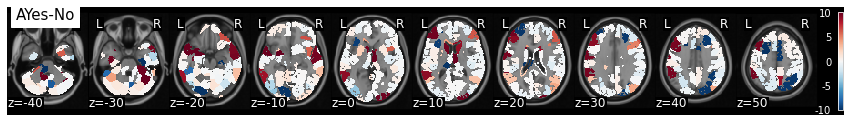

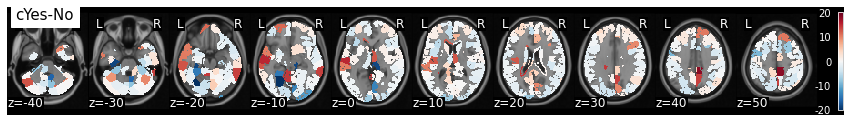

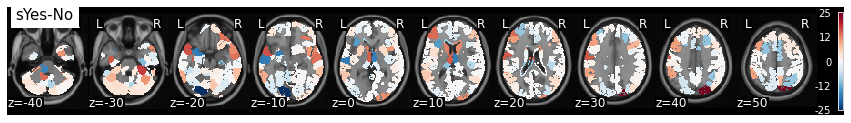

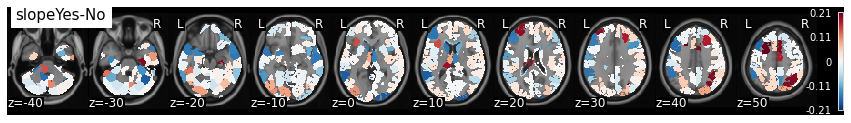

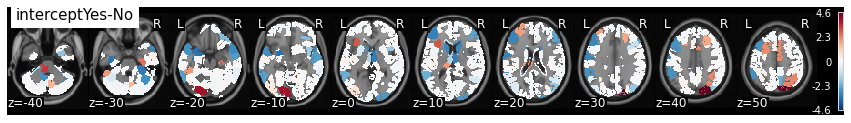

In [507]:
# same figure as above but for a single movie

movie_ind = 0

mask = Brain_Data('https://neurovault.org/media/images/8423/shen_2mm_268_parcellation.nii.gz')
mask_x = expand_mask(mask)

df2 = df_params.loc[df_params["Movie_ind"]==movie_ind,:]
rows = [int(i) for i in df2["Nodes"]]

nodes1 = np.empty((268,))
nodes1[:] =np.nan
nodes1[rows] = df2["Adiff"]
img = roi_to_brain(pd.Series(nodes1), mask_x)
img.plot(colorbar=True, title = "AYes-No", cmap = 'RdBu_r')
    
nodes2 = np.empty((268,))
nodes2[:] =np.nan
nodes2[rows] = df2["cdiff"]
img = roi_to_brain(pd.Series(nodes2), mask_x)
img.plot(colorbar=True, title =  "cYes-No", cmap = 'RdBu_r')
    
nodes3 = np.empty((268,))
nodes3[:] =np.nan
nodes3[rows] = df2["sdiff"]
img = roi_to_brain(pd.Series(nodes3), mask_x)
img.plot(colorbar=True, title = "sYes-No", cmap = 'RdBu_r')

nodes4 = np.empty((268,))
nodes4[:] =np.nan
nodes4[rows] = df2["slopediff"]
img = roi_to_brain(pd.Series(nodes4), mask_x)
img.plot(colorbar=True, title = "slopeYes-No", cmap = 'RdBu_r')


nodes5 = np.empty((268,))
nodes5[:] =np.nan
nodes5[rows] = df2["interceptdiff"]
img = roi_to_brain(pd.Series(nodes5), mask_x)
img.plot(colorbar=True, title = "interceptYes-No", cmap = 'RdBu_r')


In [493]:
pd.set_option('display.max_colwidth', None) # so columns are not snipped

# loading the Shen atlas labels
shen268 = pd.read_csv(os.path.join(data_file_loc,"shen_dictionary.csv"))
shen268.head()

,1,2,3,4,5,6,7,8,9,10,...,259,260,261,262,263,264,265,266,267,268
0,"{'coords': [14.083200000000005, 56.6944, -16.684799999999996], 'name': '92.80% Frontal_Pole; 7.20% Frontal_Medial_Cortex'}","{'coords': [9.599999999999994, 17.61882352941177, -19.53411764705882], 'name': '60.56% Subcallosal_Cortex; 38.73% Frontal_Orbital_Cortex'}","{'coords': [5.270633397312864, 35.03262955854126, -17.5278310940499], 'name': '58.54% Frontal_Medial_Cortex; 34.55% Subcallosal_Cortex'}","{'coords': [15.647840531561457, 34.18604651162792, -22.544850498338867], 'name': '54.15% Frontal_Pole; 41.86% Frontal_Orbital_Cortex'}","{'coords': [8.283887468030684, 46.05882352941177, -1.6700767263427139], 'name': '47.25% Paracingulate_Gyrus; 25.03% Cingulate_Gyrus_anterior_division; 16.35% Frontal_Medial_Cortex; 10.86% Frontal_Pole'}","{'coords': [14.581460674157299, 64.75280898876406, 3.682584269662925], 'name': '100.00% Frontal_Pole'}","{'coords': [30.41914191419142, 54.79537953795381, -3.3267326732673297], 'name': '100.00% Frontal_Pole'}","{'coords': [44.469325153374236, 46.095092024539866, -4.917177914110425], 'name': '99.85% Frontal_Pole'}","{'coords': [28.814814814814817, 51.163163163163176, 18.73473473473473], 'name': '100.00% Frontal_Pole'}","{'coords': [8.521081081081078, 53.28, 23.885405405405407], 'name': '48.54% Frontal_Pole; 32.43% Paracingulate_Gyrus; 19.03% Superior_Frontal_Gyrus'}",...,"{'coords': [-10.399527186761233, 10.877068557919614, -8.056737588652481], 'name': '20.66% Subcallosal_Cortex; 19.95% Left_Putamen; 19.83% Left_Accumbens; 14.40% Left_Caudate; 13.81% no_label; 5.67% Frontal_Orbital_Cortex'}","{'coords': [-14.491582491582491, -3.54882154882155, 20.909090909090907], 'name': '55.03% Left_Caudate; 29.53% Left_Lateral_Ventrical; 11.07% Left_Thalamus'}","{'coords': [-24.77079107505071, 5.537525354969574, -0.07302231237322587], 'name': '96.96% Left_Putamen'}","{'coords': [-9.427230046948353, -25.539906103286384, -1.3755868544600958], 'name': '72.56% Left_Thalamus; 21.40% Brain-Stem; 5.58% no_label'}","{'coords': [-4.68474576271187, -10.2406779661017, 5.877966101694909], 'name': '82.71% Left_Thalamus; 13.90% Left_Lateral_Ventrical'}","{'coords': [-11.407792207792212, -25.563636363636363, 14.883116883116884], 'name': '61.82% Left_Thalamus; 31.43% Left_Lateral_Ventrical'}","{'coords': [-4.821052631578951, -21.51157894736842, -15.890526315789472], 'name': '71.16% Brain-Stem; 25.89% no_label'}","{'coords': [-4.227272727272734, -37.89772727272728, -53.26704545454545], 'name': '100.00% Brain-Stem'}","{'coords': [-6.9375, -33.13068181818181, -39.34659090909091], 'name': '99.15% Brain-Stem'}","{'coords': [-5.697885196374628, -18.966767371601208, -36.81570996978852], 'name': '100.00% Brain-Stem'}"


### work in progress section

96.72% Cingulate_Gyrus_anterior_division


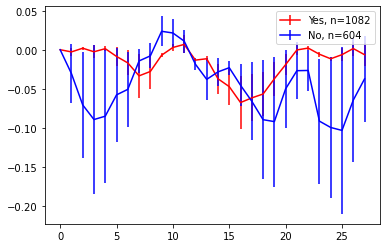

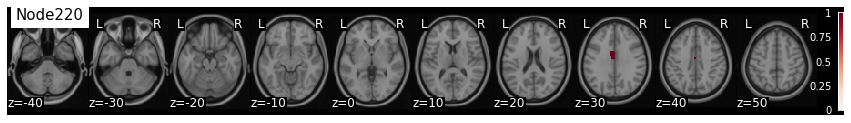

In [150]:
# plotting timecourses for a single node.. need to update code

node_ind = 219
node = node_ind+1
lbl = ['Yes','No']
    
nt = 28
yyes_array = np.empty((10,nt))
yno_array = np.empty_like(yyes_array)
yyes_array[:] = np.nan
yno_array[:] = np.nan
for m in range(10):
    yyes = []
    yno = []
    arr = df.loc[df['Movie_ind']==m,'Nodes'].values
    if len(np.where(arr==node_ind)[0])>0: # If this node was fit for this movie
        mat = movieTC_all[m]# nsubs * nnodes * ntimepts
        for sub in range(mat.shape[0]):
            if responses_slopereg[sub,m] == 1:
                yyes.append(mat[sub,node_ind,:nt])
            elif responses_slopereg[sub,m] == 0:
                yno.append(mat[sub,node_ind,:nt])
        yyes_array[m,:] = np.mean(np.array(yyes),axis = 0)
        yno_array[m,:] = np.mean(np.array(yno),axis = 0)

plt.errorbar(x = range(nt),y = np.nanmean(yyes_array, axis = 0), 
         yerr = stats.sem(yyes_array,axis = 0, nan_policy='omit'), color = 'r', 
             label = lbl[0] + ', n=' + str(nrows[0]))
plt.errorbar(x = range(nt),y = np.nanmean(yno_array, axis = 0), 
         yerr = stats.sem(yno_array,axis = 0,nan_policy='omit'), color = 'b', 
             label = lbl[1] + ', n=' + str(nrows[1]))
plt.legend()

# Nodes can be viewed here: https://bioimagesuiteweb.github.io/webapp/connviewer.html
dict = eval(shen268[str(node)][0])
print(dict['name'])

mat = np.zeros((268,))

mat[node-1] = 1
img = roi_to_brain(pd.Series(mat), mask_x) # plot max difference timepoint for each node
img.plot(colorbar=True, title = 'Node' + str(node), cmap = 'RdBu_r')

In [145]:
nsubs

[1082, 604]

In [78]:
for node_ind in range(134):
    dict = eval(shen268[str(node_ind +1)][0])
    nodename =dict['name']
    #print(nodename) 
    if nodename.find("Temporal") != -1:
        print(node_ind,nodename)

17 89.61% Frontal_Orbital_Cortex; 7.97% Temporal_Pole
35 60.69% Frontal_Orbital_Cortex; 31.21% Insular_Cortex; 6.36% Temporal_Pole
45 30.14% Parietal_Operculum_Cortex; 28.13% Planum_Temporale; 14.65% Supramarginal_Gyrus_posterior_division; 13.38% Supramarginal_Gyrus_anterior_division; 7.69% Superior_Temporal_Gyrus_posterior_division
49 35.64% Angular_Gyrus; 25.13% Middle_Temporal_Gyrus_temporooccipital_part; 22.21% Lateral_Occipital_Cortex_inferior_division; 16.62% Lateral_Occipital_Cortex_superior_division
50 99.23% Temporal_Pole
51 99.80% Temporal_Pole
52 79.58% Temporal_Pole; 11.32% Middle_Temporal_Gyrus_anterior_division; 6.53% Superior_Temporal_Gyrus_anterior_division
53 44.25% Middle_Temporal_Gyrus_posterior_division; 31.27% Superior_Temporal_Gyrus_posterior_division; 19.17% Middle_Temporal_Gyrus_temporooccipital_part; 5.01% Supramarginal_Gyrus_posterior_division
54 51.45% Inferior_Temporal_Gyrus_posterior_division; 48.41% Middle_Temporal_Gyrus_posterior_division
55 35.86% Middle

In [44]:
yyes_array.shape

(4910, 43)

### Individual-level curve fits - work in progress

In [516]:
movieTC_all = []
for m in range(10):
    fileName = os.path.join(data_file_loc,f'timecourse-movie{movie_ind}.npy')
    mat = np.load(fileName)
    mat = mat[:,:,:28]
    movieTC_all.append(mat) # nsubs * nnodes * ntimepts

In [585]:

def fit_params_sub(movieTC_all,sub_ind,r2_thr, fn, responses, node_plot=0, sub_plot=-1):
    # incomplete.. code to get fit info at the subject level
    
    resp_any = (responses[sub_ind,:] == 0)| (responses[sub_ind,:] == 1) | \
                (responses[sub_ind,:] == 9)
    
    mat_sub = np.empty((10,268,28)) #movie,node,timept
    for m in range(10):
        mat_sub[m,:,:] = movieTC_all[m][sub_ind,:,:]
        
    #print('mat_sub:', mat_sub)
    # mean timecourses across yes/no responders for a certain movie (defined in the previous node)
    meanTimecourse_anyresp = np.nanmean(mat_sub[resp_any,:,:],axis = 0) # nodes, timepts
    #print('meanTimecourse_anyresp:',meanTimecourse_anyresp)
    r2_all    = np.empty((268,1)) # nodes, best fn as determined from mean
    r2_all[:] = np.nan
    
    aic_all    = np.empty((268,1)) # nodes, 
    aic_all[:] = np.nan
    
    if fn ==2:
        nparams = 5
    
    #params_array   = np.empty((268,nparams)) # nodes, params, yes/no/unsure/all
    #params_array[:]= np.nan
    
    if len(np.where(resp_any)[0]) > 0: # there is at least 1 resp/sub
        for node in range(268):
            yanyresp = meanTimecourse_anyresp[node,:]
            if (node == node_plot-1) and (sub_ind == sub_plot):
                plot_fig = 1
            else:
                plot_fig = 0

            if fn == 0:
                _,param_keys,r2,aic = logfit(yanyresp,r2_thr,plot_fig)
            elif fn == 1:
                _,param_keys,r2,aic = linfit(yanyresp,r2_thr,plot_fig)
            elif fn == 2:
                _,param_keys,r2,aic = loglinfit(yanyresp,r2_thr,plot_fig)
            elif fn == 3:
                _,param_keys,r2,aic = sinefit(yanyresp,r2_thr,plot_fig)
            elif fn == 4:
                _,param_keys,r2,aic = linsinefit(yanyresp,r2_thr,plot_fig)

            #params_array[node,:] = params_best
            r2_all[node] = r2
            aic_all[node] = aic

    return r2_all, aic_all

In [588]:
# incomplete: code to get fit info for each subject (i.e. run above function)
#del df
r2_thr = .6
colnames = ['Movie_ind', 'Nodes', 'Rsq_Loglinear', 'AIC_Loglinear']
sub_plot = -1 # enter a sub_ind value between 0 an 1049, -1 to not plot
node_plot = 0 # Enter a value between 1 and 268?(incl.). Will subtract by 1 in the functiom

df_fit_sub = pd.DataFrame(columns = colnames) 
start = time.time()
nsub = movieTC_all[0].shape[0]
for sub_ind in np.arange(0,nsub): # 
    if sub_ind%10 == 0:
        print(f'Elapsed time: {time.time()-start}, sub_ind:{sub_ind}')
    r2_all, aic_all = \
        fit_params_sub(movieTC_all,sub_ind,r2_thr, fn, responses, node_plot, sub_plot=-1)
    
    sub_ind_col= np.repeat(sub_ind,268, axis=0)
    sub_ind_col = np.reshape(sub_ind_col,(268,1))
    
    nodes_ind = np.arange(0,268)
    nodes_ind = np.reshape(nodes_ind,(268,1))
    
    dat = np.hstack((sub_ind_col, nodes_ind, r2_all, aic_all))
    #print(dat)
    new_row = pd.DataFrame(dat, columns = colnames)
    df_fit_sub = pd.concat([df_fit_sub, new_row], ignore_index=True)

df_fit_sub.head()

Elapsed time: 0.00015401840209960938, sub_ind:0
Elapsed time: 34.81354999542236, sub_ind:10
Elapsed time: 70.18051409721375, sub_ind:20
Elapsed time: 107.73156595230103, sub_ind:30
Elapsed time: 139.16720604896545, sub_ind:40
Elapsed time: 175.55535507202148, sub_ind:50
Elapsed time: 211.67171216011047, sub_ind:60


<ipython-input-585-04af41872ded>:14: RuntimeWarning: Mean of empty slice
  meanTimecourse_anyresp = np.nanmean(mat_sub[resp_any,:,:],axis = 0) # nodes, timepts


Elapsed time: 244.54225206375122, sub_ind:70
Elapsed time: 277.62468099594116, sub_ind:80
Elapsed time: 311.7245910167694, sub_ind:90
Elapsed time: 346.87907910346985, sub_ind:100
Elapsed time: 381.83016705513, sub_ind:110
Elapsed time: 415.7782611846924, sub_ind:120
Elapsed time: 452.2477059364319, sub_ind:130
Elapsed time: 484.403382062912, sub_ind:140
Elapsed time: 519.2763869762421, sub_ind:150
Elapsed time: 553.0484459400177, sub_ind:160
Elapsed time: 586.9213619232178, sub_ind:170
Elapsed time: 618.7792699337006, sub_ind:180
Elapsed time: 2308.8036499023438, sub_ind:190
Elapsed time: 2343.6067101955414, sub_ind:200
Elapsed time: 2377.92804312706, sub_ind:210
Elapsed time: 2413.1109919548035, sub_ind:220
Elapsed time: 2444.2355439662933, sub_ind:230
Elapsed time: 2481.0030019283295, sub_ind:240
Elapsed time: 2521.1876199245453, sub_ind:250
Elapsed time: 2558.586769104004, sub_ind:260
Elapsed time: 2600.3498499393463, sub_ind:270
Elapsed time: 2636.7542400360107, sub_ind:280
Elapse

UnboundLocalError: local variable 'result' referenced before assignment

In [538]:
def response_based_params_sub(movieTC_all, sub_ind, responses, fn, node_plot=0,sub_plot=-1):
    # fn to get response-based info at the subject level...incomplete
    
    # get yes/no indices
    resp_yes = responses[sub_ind,:] == 1 # yes response indices
    resp_no = responses[sub_ind,:] == 0
    #resp_unsure = responses[sub_ind,:] == 9
    #resp_any = (responses[sub_ind,:] == 0)| (responses_slopereg[sub_ind,:] == 1) | (responses_slopereg[sub_ind,:] == 9)

    # mean timecourses across yes/no responders for a certain movie (defined in the previous node)
    mat_sub = np.empty((10,268,28)) #movie,node,timept
    for m in range(10):
        mat_sub[m,:,:] = movieTC_all[m][sub_ind,:,:]
        
   # meanTimecourse_anyresp = np.mean(mat_sub[resp_any,:,:],axis = 0) # nodes, timepts
    meanTimecourse_yes = np.mean(mat_sub[resp_yes,:,:],axis = 0) # nodes, timepts
    meanTimecourse_no = np.mean(mat_sub[resp_no,:,:],axis = 0) # nodes, timepts
    #meanTimecourse_unsure= np.mean(mat_sub[resp_unsure,:,:],axis = 0) # nodes, timepts
    if fn ==2:
        nparams = 5
    
    params_array_yes   = np.empty((268,nparams)) # nodes, params, yes/no/unsure/all
    params_array_yes[:]= np.nan
    params_array_no    = np.empty_like(params_array_yes)
    params_array_no[:] = np.nan
    
    for resp_type in ['Yes','No']:
        for node in range(268):
            
            y = meanTimecourse_yes[node,:] if resp_type ==  'Yes' else meanTimecourse_no[node,:]
            
            plot_fig = 0
            if node_plot > 0:
                if (node == node_plot-1) and (sub_ind == sub_plot):
                    plot_fig = 1
                    print(str.upper(resp_type))
                  
            if fn == 0:
                params_best,param_keys,_,_ = logfit(y,r2_thr,plot_fig)
            elif fn == 1:
                params_best,param_keys,_,_ = linfit(y,r2_thr,plot_fig)
            elif fn == 2:
                #print(y)
                params_best,param_keys,_,_ = loglinfit(y,r2_thr,plot_fig)
            elif fn == 3:
                params_best,param_keys,_,_ = sinefit(y,r2_thr,plot_fig)
            elif fn == 4:
                params_best,param_keys,_,_ = linsinefit(y,r2_thr,plot_fig)
            
            if resp_type == 'Yes':
                params_array_yes[node,:] = params_best
            elif resp_type == 'No':
                params_array_no[node,:] = params_best

    
    return params_array_yes,params_array_no

In [539]:
# code to get best fit params at the subject level.. incomplete..
#del df

r2_thr = .6
fn = 2
if fn == 2:
    colnames = ['Sub_ind', 'Nodes','slopeYes','interceptYes', 'AYes','cYes','sYes',
            'slopeNo','interceptNo','ANo','cNo','sNo', ]

node_plot = 0#0 to not plot, 1-268 to plot
sub_plot = 0 #subindex to be plotted
df_params_sub = pd.DataFrame(columns = colnames) 

nodes_ind = np.arange(0,268)
nodes_ind = np.reshape(nodes_ind,(268,1))

nsub = 10
#dat_params_sub = np.empty((268*nsub,12))
start = time.time()
for sub_ind in range(nsub): # list of subs. 1049 in total
    print(f'Elapsed time:{time.time()-start}, sub:{sub_ind}')
    
    if df_fit_sub['R']
    
    params_yes, params_no = response_based_params_sub(movieTC_all, sub_ind, responses, fn, 
                                                     node_plot, sub_plot)
    
    sub_ind_col= np.repeat(sub_ind,268, axis=0)
    sub_ind_col = np.reshape(sub_ind_col,(268,1))
    
    #rows = np.arange(sub_ind*268,(sub_ind+1)*268)
    #dat_params_sub[rows,:] = np.hstack((sub_ind_col, nodes_ind, params_yes, params_no))
    #print(dat)
    new_row = pd.DataFrame(dat, columns = colnames)
    df_params_sub = pd.concat([df_params, new_row], ignore_index=True)

df_params_sub.head()

Elapsed time:0.00024199485778808594, sub:0
Elapsed time:7.016031980514526, sub:1
Elapsed time:13.047888278961182, sub:2
Elapsed time:21.21273922920227, sub:3
Elapsed time:27.158380031585693, sub:4
Elapsed time:34.30989599227905, sub:5
Elapsed time:42.15437698364258, sub:6
Elapsed time:50.241881132125854, sub:7
Elapsed time:58.39530611038208, sub:8
Elapsed time:68.26670908927917, sub:9


,Movie_ind,Nodes,slopeYes,interceptYes,AYes,cYes,sYes,slopeNo,interceptNo,ANo,cNo,sNo,slopediff,interceptdiff,Adiff,cdiff,sdiff,Rsq_Loglinear,Sub_ind
0,0.0,0.0,-0.011736,-0.014541,0.445481,17.074008,4.655293,0.001933,0.032673,0.172069,15.439310,1.314751,-0.013669,-0.047213,0.273412,1.634699,3.340542,0.985410,NaN
1,0.0,2.0,-0.005541,0.003614,0.119382,19.556532,1.942989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.948139,NaN
2,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.616308,NaN
3,0.0,4.0,-0.016032,0.055651,0.248153,20.496334,1.348063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.878967,NaN
4,0.0,5.0,-0.010370,0.022174,0.333346,20.455682,2.033506,-0.013849,0.004951,0.252896,21.045267,1.957315,0.003479,0.017223,0.080450,-0.589585,0.076191,0.893562,NaN
